In [272]:
import numpy as np
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patches as ptchs
from matplotlib import gridspec
import matplotlib.text as mtext

import scipy.integrate
import scipy.optimize
from sklearn.linear_model import Ridge

import pandas as pd
from pandas.core.base import PandasObject

system = "a100"
vd_input_folder = f"{system}-cpu/"
mb_input_folder = f"../microbenchmarks/{system}/"
output_folder = f"../../images/{system}"
%run ../notebook_setup.ipynb

# Validation Data

## Inner validation

In [277]:
# validation_results = "das6-cpu/20231127-223143" 
inner_validation_results = f"{vd_input_folder}/inner_validation" 
inner_validation_df = pd.read_csv(inner_validation_results)
inner_validation_df["nvals"] =  inner_validation_df["input"].apply(lambda s: float(s.split("_")[-1].split(".")[0]))
inner_validation_df["distribution"] =  inner_validation_df["input"].apply(lambda s: s.split("_")[1])
convert_to_type(inner_validation_df, "tfindbin", np.float64)
convert_to_type(inner_validation_df, "tfill", np.float64)
convert_to_type(inner_validation_df, "tstats", np.float64)
convert_to_type(inner_validation_df, "edges", np.bool_)
del inner_validation_df["input"]
inner_validation_df

,iter,env,nthreads,nbins,bulksize,edges,tfindbin,tfill,tstats,ttotal,nvals,distribution
0,0,CPU,1,10,1,False,1.155329,0.925734,0.920759,6.457331,5.000000e+07,uniform
1,0,CPU,1,10,1,False,2.311850,1.840477,1.837254,12.942383,1.000000e+08,uniform
2,0,CPU,1,10,1,False,11.578833,9.186845,9.186840,64.610835,5.000000e+08,uniform
3,0,CPU,1,10,1,False,23.112685,18.395353,18.365658,127.825096,1.000000e+09,uniform
4,0,CPU,1,10,1,False,1.154813,0.920748,0.918750,6.356626,5.000000e+07,constant-0.5
...,...,...,...,...,...,...,...,...,...,...,...,...
4475,4,CPU,1,10000000,262144,True,242.513228,99.772572,18.643947,393.134477,1.000000e+09,normal-0.4-0.1
4476,4,CPU,1,10000000,262144,True,8.380359,4.823029,0.932594,15.921631,5.000000e+07,normal-0.7-0.01
4477,4,CPU,1,10000000,262144,True,16.566873,9.748802,1.862643,31.561149,1.000000e+08,normal-0.7-0.01
4478,4,CPU,1,10000000,262144,True,81.241930,41.907838,9.318702,148.727149,5.000000e+08,normal-0.7-0.01


## Total validation

In [278]:
validation_results = f"{vd_input_folder}/validation" 
validation_df = pd.read_csv(validation_results)
validation_df["nvals"] =  validation_df["input"].apply(lambda s: float(s.split("_")[-1].split(".")[0]))
validation_df["distribution"] =  validation_df["input"].apply(lambda s: s.split("_")[1])
convert_to_type(validation_df, "tfindbin", np.float64)
convert_to_type(validation_df, "tfill", np.float64)
convert_to_type(validation_df, "tstats", np.float64)
convert_to_type(validation_df, "edges", np.bool_)
del validation_df["input"]
validation_df

,iter,env,nthreads,nbins,bulksize,edges,tfindbin,tfill,tstats,ttotal,nvals,distribution
0,0,CPU,1,10,1,False,0.0,0.0,0.0,2.888917,5.000000e+07,uniform
1,0,CPU,1,10,1,False,0.0,0.0,0.0,5.865390,1.000000e+08,uniform
2,0,CPU,1,10,1,False,0.0,0.0,0.0,28.588938,5.000000e+08,uniform
3,0,CPU,1,10,1,False,0.0,0.0,0.0,57.618172,1.000000e+09,uniform
4,0,CPU,1,10,1,False,0.0,0.0,0.0,2.796339,5.000000e+07,constant-0.5
...,...,...,...,...,...,...,...,...,...,...,...,...
4475,4,CPU,1,10000000,262144,True,0.0,0.0,0.0,259.368872,1.000000e+09,normal-0.4-0.1
4476,4,CPU,1,10000000,262144,True,0.0,0.0,0.0,8.374019,5.000000e+07,normal-0.7-0.01
4477,4,CPU,1,10000000,262144,True,0.0,0.0,0.0,16.785966,1.000000e+08,normal-0.7-0.01
4478,4,CPU,1,10000000,262144,True,0.0,0.0,0.0,80.592285,5.000000e+08,normal-0.7-0.01


In [279]:
gp_ivd = inner_validation_df.groupby(["env", "distribution", "nvals", "nbins", "bulksize", "edges"])
gp_ivd.mean()

iter  nthreads  \
env distribution nvals        nbins    bulksize edges                   
CPU constant-0.5 5.000000e+07 10       1        False   2.0       1.0   
                                                True    2.0       1.0   
                                       8        False   2.0       1.0   
                                                True    2.0       1.0   
                                       64       False   2.0       1.0   
...                                                     ...       ...   
    uniform      1.000000e+09 10000000 4096     True    2.0       1.0   
                                       32768    False   2.0       1.0   
                                                True    2.0       1.0   
                                       262144   False   2.0       1.0   
                                                True    2.0       1.0   

                                                         tfindbin       tfill  \
env distribution nvals        nbins    bulksize edges                           
CPU constant-0.5 5.000000e+07 10       1        False    1.158548    0.919304   
                                                True     1.105650    0.930071   
                                       8        False    1.154280    0.921210   
                                                True     1.107974    0.920789   
                                       64       False    1.154662    0.918936   
...                                                           ...         ...   
    uniform      1.000000e+09 10000000 4096     True   330.447468  107.959589   
                                       32768    False   23.145996   81.256418   
                                                True   340.479733  109.464767   
                                       262144   False   23.158885   87.322467   
                                                True   326.299550  108.654138   

                                                          tstats      ttotal  
env distribution nvals        nbins    bulksize edges                         
CPU constant-0.5 5.000000e+07 10       1        False   0.918678    6.445233  
                                                True    0.918592    6.442759  
                                       8        False   0.918903    5.062158  
                                                True    0.918527    5.013738  
                                       64       False   0.923312    4.560136  
...                                                          ...         ...  
    uniform      1.000000e+09 10000000 4096     True   18.633998  488.520367  
                                       32768    False  18.512484  153.645627  
                                                True   18.664191  500.467606  
                                       262144   False  18.429279  160.065792  
                                                True   18.639879  485.883644  

[896 rows x 6 columns]

In [280]:
gp_vd = validation_df.groupby(["env", "distribution", "nvals", "nbins", "bulksize", "edges"])
gp_vd.mean()

iter  nthreads  \
env distribution nvals        nbins    bulksize edges                   
CPU constant-0.5 5.000000e+07 10       1        False   2.0       1.0   
                                                True    2.0       1.0   
                                       8        False   2.0       1.0   
                                                True    2.0       1.0   
                                       64       False   2.0       1.0   
...                                                     ...       ...   
    uniform      1.000000e+09 10000000 4096     True    2.0       1.0   
                                       32768    False   2.0       1.0   
                                                True    2.0       1.0   
                                       262144   False   2.0       1.0   
                                                True    2.0       1.0   

                                                       tfindbin  tfill  \
env distribution nvals        nbins    bulksize edges                    
CPU constant-0.5 5.000000e+07 10       1        False       0.0    0.0   
                                                True        0.0    0.0   
                                       8        False       0.0    0.0   
                                                True        0.0    0.0   
                                       64       False       0.0    0.0   
...                                                         ...    ...   
    uniform      1.000000e+09 10000000 4096     True        0.0    0.0   
                                       32768    False       0.0    0.0   
                                                True        0.0    0.0   
                                       262144   False       0.0    0.0   
                                                True        0.0    0.0   

                                                       tstats      ttotal  
env distribution nvals        nbins    bulksize edges                      
CPU constant-0.5 5.000000e+07 10       1        False     0.0    2.812488  
                                                True      0.0    2.916937  
                                       8        False     0.0    1.064122  
                                                True      0.0    1.189711  
                                       64       False     0.0    0.557256  
...                                                       ...         ...  
    uniform      1.000000e+09 10000000 4096     True      0.0  300.067945  
                                       32768    False     0.0   35.162782  
                                                True      0.0  303.833515  
                                       262144   False     0.0   37.363417  
                                                True      0.0  307.899557  

[896 rows x 6 columns]

In [282]:
unique_nbins = validation_df["nbins"].unique().astype(np.float64)
unique_nvals = validation_df["nvals"].unique().astype(np.float64)
unique_bulksize = validation_df["bulksize"].unique().astype(np.float64)
unique_distribution = validation_df["distribution"].unique()
unique_edges = [True, False]
unique_nbins, unique_nvals, unique_bulksize, unique_distribution, unique_edges

(array([1.e+01, 1.e+03, 1.e+05, 1.e+07]),
 array([5.e+07, 1.e+08, 5.e+08, 1.e+09]),
 array([1.00000e+00, 8.00000e+00, 6.40000e+01, 5.12000e+02, 4.09600e+03,
        3.27680e+04, 2.62144e+05]),
 array(['uniform', 'constant-0.5', 'normal-0.4-0.1', 'normal-0.7-0.01'],
       dtype=object),
 [True, False])

## LMBench

In [290]:
lmbench_results = f"{mb_input_folder}/lmbench"
with open(lmbench_results, "r") as f:
    lines = f.readlines()
    latencies = {}
    sizes = {}
    for l in lines:            
        if "stride" in l:
            stride = int(l.split("=")[1])
            latencies[stride] = []
            sizes[stride] = []
            continue

        if "." in l:
            latencies[stride].append(float(l.split()[1]))
            sizes[stride].append( float(l.split()[0]) * unit_to_unit_factor("mb", "b", bytes=True) )

# latencies, sizes

In [291]:
########### LMBench values
T_l1 = 1.4
T_l2 = 4
T_l3 = 24
T_mem = 80

l1_size = 49152
l2_size = 1310720
l3_size = 37748736

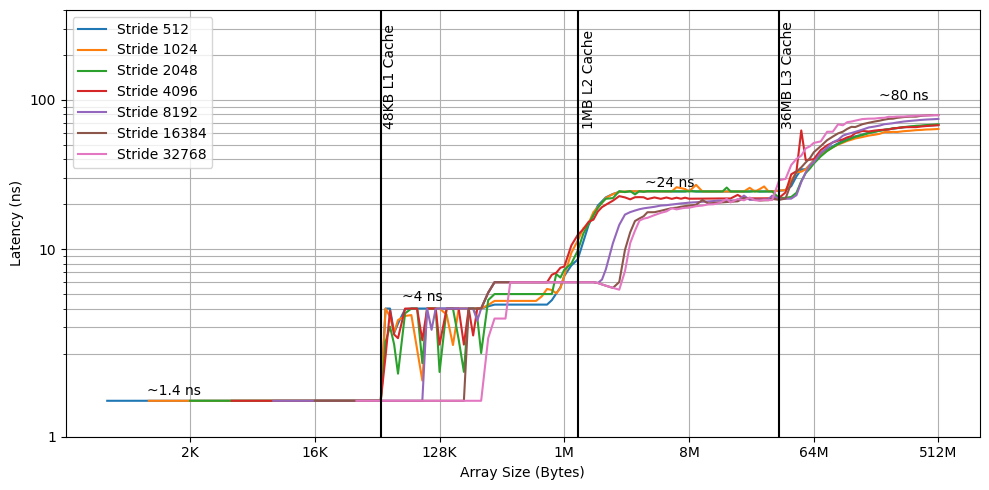

In [292]:
save =True;figname=f"{output_folder}/lmbench.pdf"
########### LMBench plot ###########
plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
for k,v in sizes.items():
    plt.plot(v, latencies[k], label=f"Stride {k}")

hmax = 400
div = 6
plt.vlines(l1_size, ymin=0, ymax=hmax, color="k" )
plt.text(l1_size + 1500, hmax/div, f"{human_readable(l1_size, bytes=True)}B L1 Cache", rotation=90)
plt.vlines(l2_size, ymin=0, ymax=hmax, color="k" )
plt.text(l2_size + 100500, hmax/div, f"{human_readable(l2_size, bytes=True)}B L2 Cache", rotation=90)
plt.vlines(l3_size, ymin=0, ymax=hmax, color="k" )
plt.text(l3_size + 1000000, hmax/div, f"{human_readable(l3_size, bytes=True)}B L3 Cache", rotation=90)

offset=0.5
hlx=0.005
# plt.hlines(1.4, xmin=0, xmax=1e9, color="k")
plt.text(1e3, T_l1 + 0.1, f"~{T_l1} ns")
# plt.hlines(4, xmin=0, xmax=1e9, color="gray")
plt.text(70e3, T_l2 + offset, f"~{T_l2} ns")
# plt.hlines(24, xmin=0, xmax=1e9, color="gray")
plt.text(4e6, T_l3 + 2, f"~{T_l3} ns")
# plt.hlines(80, xmin=0, xmax=1e9, color="gray")
plt.text(200e6, T_mem + 20, f"~{T_mem} ns")

plt.legend()

plt.xlabel("Array Size (Bytes)")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x), bytes=True)}"))# 
# plt.xlim([0.0005, 32])
# plt.ticklabel_format(axis='x', style='plain')

plt.ylabel("Latency (ns)")
plt.yscale("symlog")
plt.ylim([1, hmax])
yaxis = plt.gca().yaxis
yaxis.set_minor_locator(MinorSymLogLocator(1e-1))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
plt.grid(True, which="both")

# plt.title("LMBench results of memory read latency with different strides and array sizes on ")
plt.tight_layout()
if save: plt.savefig(figname,format="pdf")
plt.show()

# Find Bin

## Design

In [293]:
def T_bscm(cache_size, sub_size, nbins):
    return (np.log2(nbins) - np.log2(cache_size) + 1).clip(0)

def T_binsearch(nbins, subsize=None):
    return (np.log2(nbins) * T_l1 
        + T_bscm(l1_size/8, subsize, nbins) * T_l2 + T_bscm(l2_size/8, subsize, nbins) * T_l3
        +  T_bscm(l3_size, subsize, nbins) * T_mem)
    
def T_findbin(edges, nbins, subsize):
    if edges:
        return T_binsearch(nbins, subsize)
    else:
        return T_fixedsearch

## Calibration

In [295]:
filename = f"{mb_input_folder}/calibration.json" 
# filename = "../das6-cpu-microbenchmark.result" 

with open(filename, "r") as f:
    jdata = json.load(f)
bm_df = pd.DataFrame.from_dict(jdata["benchmarks"]).astype({"real_time" : float})

convert_to_type(bm_df, "real_time", np.float64)
bm_df["func_name"] = bm_df["name"].apply(lambda s: s.split("/")[0][3:])    
bm_df["time_factor"] = bm_df["time_unit"].apply(convert_unit)
# bm_df["time (s)"] = bm_df["real_time"] * bm_df["time_unit"].apply(convert_unit)
del bm_df["family_index"], bm_df["per_family_instance_index"]
bm_df["time_factor"] = bm_df["time_unit"].apply(convert_unit)

bm_df.head(10)

FileNotFoundError: [Errno 2] No such file or directory: '../microbenchmarks/a100//calibration.json'

## Validation

NameError: name 'T_fixedsearch' is not defined

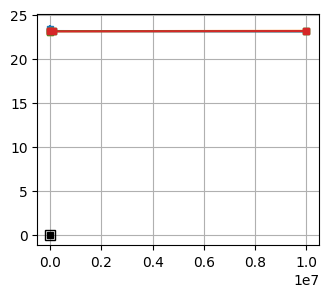

In [296]:
save = True; figname= f"{output_folder}/cpu_findbin_validation.pdf"
####### nbins vs nvals, distr subplots ###########

selected_env = "CPU" 
selected_bulksize = 32768
selected_nbins = unique_nbins
selected_nvals = 1e9
selected_distr = sorted(unique_distribution)
selected_edges = False
unit = "s"

fig = plt.figure(figsize=(8, 3))
ax = plt.subplot(121)

# Legend Labels
plot_validation_labels()

for di,distr in enumerate(selected_distr):
    arg = selected_env, distr, selected_nvals, selected_nbins, selected_bulksize, False
    avg = gp_ivd.mean().loc[arg]
    std = gp_ivd.std().loc[arg]
    
    p = ax.errorbar(selected_nbins, avg["tfindbin"], 
                     yerr=std["tfindbin"], 
                     **bm_style,
                )
    

    # Legend Labels
    ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, 
                                 facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"))

## prediction
subsize = get_subsize(distr, selected_nbins)
pred = T_findbin(False, selected_nbins, subsize) * unit_to_unit_factor("ns", unit) * selected_nvals 
subsize = selected_nbins
ax.errorbar(selected_nbins, 
             np.repeat(pred, len(selected_nbins)), 
             c=pred_color,
             **pred_nocolor_style
            )


plt.xlabel("Number of bins")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))

plt.ylabel("Runtime (s)")
yaxis = plt.gca().yaxis
ax.grid(True, which="major")
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))

##############3
ax = plt.subplot(122)

# Legend Labels
plot_validation_labels()

for di,distr in enumerate(selected_distr):
    arg = selected_env, distr, selected_nvals, selected_nbins, selected_bulksize, True
    avg = gp_ivd.mean().loc[arg]
    std = gp_ivd.std().loc[arg]
    
    p = ax.errorbar(selected_nbins, avg["tfindbin"], 
                     yerr=std["tfindbin"], 
                    **bm_style,
                 # label=f"{int(nb)} bin{'s' if int(nb) > 1 else ''}"
                 # label=f"{distr}"
                )
    

    # Legend Labels
    ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, 
                                 facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"))

## prediction
pred_color=p[0].get_color()
subsize = get_subsize(distr, selected_nbins)
pred = T_findbin(True, selected_nbins, subsize) * unit_to_unit_factor("ns", unit) * selected_nvals     
ax.errorbar(selected_nbins, 
             np.repeat(pred, len(selected_nbins)), 
             c=pred_color,
             **pred_nocolor_style
             # label=f"Prediction {int(nb)} bin{'s' if int(nb) > 1 else ''}"
            )

observ = avg["tfindbin"].values
print(distr, pred, mae(pred, observ), r2(pred, observ) * 100)

plt.xlabel("Number of bins")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))

plt.ylabel("Runtime (s)")
# plt.yscale("symlog")
# plt.ylim([0,1000])
yaxis = plt.gca().yaxis
yaxis.set_minor_locator(MinorSymLogLocator(1e-1))
ax.grid(True, which="major")
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))

##########
hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Distribution")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")

legend = fig.legend(hndls, lbls, loc='center left', bbox_to_anchor=(0.99, 0.65),
                    handler_map={str: LegendTitle({'fontsize':12})})

plt.tight_layout()
plt.savefig(figname, format="pdf", bbox_inches='tight')
plt.show()

# Add Bin Content

## Design

## Calibration

## Validation

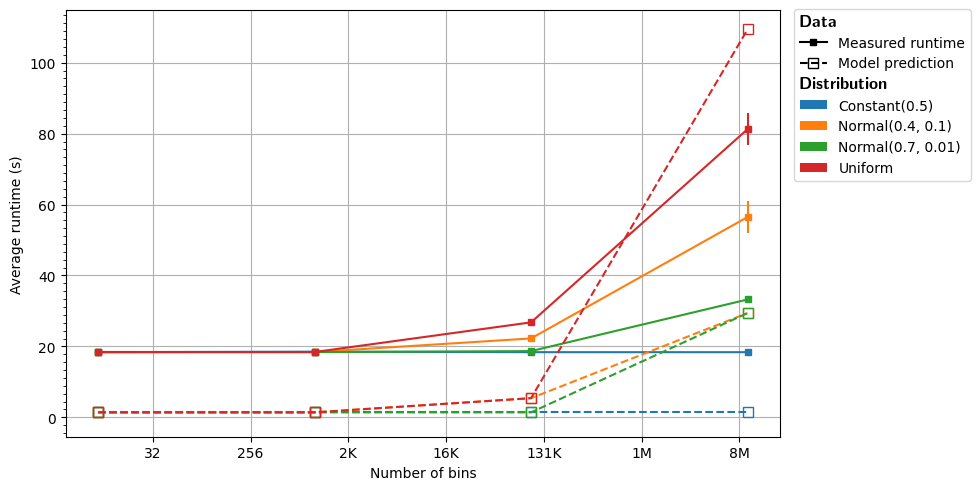

In [297]:
save=True; figname=f"{output_folder}/cpu_addbincontent_validation.pdf"

####### nbins vs nvals, distr subplots ###########
def T_fill(nbins, subsize):  
    l1_miss = (np.array(subsize) > l1_size/8).astype(np.int64)
    l2_miss = (np.array(subsize) > l2_size/8).astype(np.int64)
    l3_miss = (np.array(subsize) > l3_size/8).astype(np.int64)
    return  (
         T_l1 
        + l1_miss * T_l2 
        + l1_miss * l2_miss * T_l3
        + l1_miss * l2_miss * l3_miss * T_mem
    )

# generate Gaussian function
def gauss(x):
    return scipy.stats.norm.pdf(x, mu, sigma)
    
selected_env = "CPU" 
selected_bulksize = 32768
selected_nvals = 1e9
selected_distr = sorted(unique_distribution)
selected_edges = False

fig = plt.figure(figsize=(8, 5))
ax = plt.subplot(111)

# Legend Labels
plot_validation_labels()

for di,distr in enumerate(selected_distr):
    arg = selected_env, distr, selected_nvals, selected_nbins, selected_bulksize, selected_edges
    avg = gp_ivd.mean().loc[arg]
    std = gp_ivd.std().loc[arg]
    
    p = ax.errorbar(selected_nbins, avg["tfill"], 
                     yerr=std["tfill"], 
                     **bm_style
                )
    

    # Legend Labels
    ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, 
                                 facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"))

    
    pred_color=p[0].get_color()
    if "constant" in distr:
        subsize = np.repeat(1, len(selected_nbins))
    elif "uniform" in distr:
        subsize = selected_nbins
    elif "normal" in distr:
        mu = np.float64(distr.split("-")[1])
        sigma = np.float64(distr.split("-")[2])
        xmin = mu - 2*sigma
        xmax = mu + 2*sigma
        subsize = []
        for nb in selected_nbins:
            a = np.arange(nb)/nb
            subsize.append(lower_bound(a, xmax)[0] - lower_bound(a, xmin)[0])
        
    pred =  T_fill(selected_nbins, subsize) * selected_nvals * unit_to_unit_factor("ns", "s") 
    ax.errorbar(selected_nbins, pred, 
                c=pred_color, **pred_nocolor_style
                )

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Distribution")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")
legend = fig.legend(hndls, lbls, loc='center left', bbox_to_anchor=(0.99, 0.8),
                    handler_map={str: LegendTitle({'fontsize':12})})

plt.xlabel("Number of bins")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))

plt.ylabel("Average runtime (s)")
yaxis = plt.gca().yaxis
yaxis.set_minor_locator(MinorSymLogLocator(1e-1))
ax.grid(True, which="major")
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))

plt.tight_layout()
if save: plt.savefig(figname, format="pdf", bbox_inches='tight')
plt.show()

# Update Stats

## Design

## Calibration

In [298]:
usb_df = clb_df[clb_df["func_name"] == "UpdateStats"].copy()
n_param = len(usb_df["name"].values[0].split("/")) - 1
for i in range(n_param):
    if i == n_param - 1:
        usb_df[f"param_{i}"] = usb_df["name"].apply(lambda s: s.split("/")[i+1].split("_")[0])
    else:
        usb_df[f"param_{i}"] = usb_df["name"].apply(lambda s: s.split("/")[i+1])

usb_mean = usb_df.loc[usb_df["name"].str.contains("mean")]
usb_std = usb_df.loc[usb_df["name"].str.contains("stddev")]
# convert_to_type(
usb_mean

NameError: name 'clb_df' is not defined

In [299]:
T_updatestats = (
    usb_mean.loc[usb_mean["param_0"] == "1"]["real_time"] * 
    unit_to_unit_factor(usb_mean["time_unit"].values[0], "ns") / 
    usb_mean["repetitions"].values[0] 
)
T_updatestats

NameError: name 'usb_mean' is not defined

## Validation

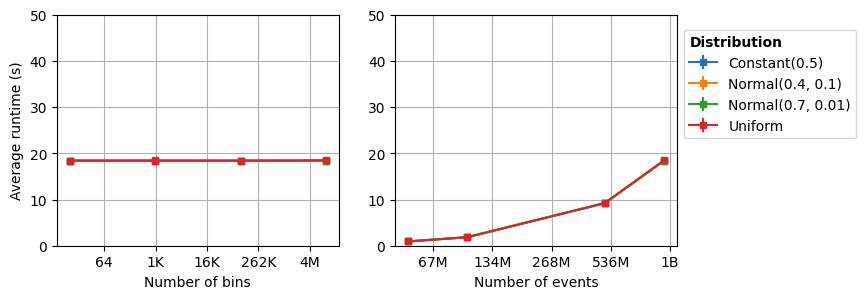

In [300]:
save = True; figname=f"{output_folder}/cpu_updatestats_validation.pdf"

selected_env = "CPU" 
selected_bulksize = 32768
selected_nbins = 10e6
selected_nvals = 1e9
selected_distr = sorted(unique_distribution)
selected_edges = False

fig = plt.figure(figsize=(8, 3))
ax = plt.subplot(121)

for di,distr in enumerate(selected_distr):
    arg = selected_env, distr, selected_nvals, unique_nbins, selected_bulksize, selected_edges
    avg = gp_ivd.mean().loc[arg]
    std = gp_ivd.std().loc[arg]
    
    p = ax.errorbar(unique_nbins, avg["tstats"], 
                     yerr=std["tstats"], 
                     **bm_style,
                 # label=f"{int(nb)} bin{'s' if int(nb) > 1 else ''}"
                    label=f"{map_distr_name(distr)}".title()
                )

# print(distr)
# pred = np.repeat(T_updatestats * selected_nvals * unit_to_unit_factor("ns", "s"), len(unique_nbins))
# ax.errorbar(unique_nbins, 
#             pred, 
#             c=pred_color,
#             marker="s", markerfacecolor="none", ls="--", markersize=7,
# )
# observ = avg["tstats"].values
# print("MAE:", mae(pred, observ))
# print("R2:", r2(pred, observ) * 100)
    
plt.xlabel("Number of bins")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
plt.ylim([0, 50])
plt.ylabel("Average runtime (s)")

ax = plt.subplot(122)
for di,distr in enumerate(selected_distr):
    arg = selected_env, distr, unique_nvals, selected_nbins, selected_bulksize, selected_edges
    avg = gp_ivd.mean().loc[arg]
    std = gp_ivd.std().loc[arg]
    
    p = ax.errorbar(unique_nvals, avg["tstats"], 
                     yerr=std["tstats"], 
                     **bm_style,
                 # label=f"{int(nb)} bin{'s' if int(nb) > 1 else ''}"
                 label=f"{map_distr_name(distr)}".title()
                )

# pred = T_updatestats[0] * unique_nvals * unit_to_unit_factor("ns", "s")
# ax.errorbar(unique_nvals, 
#             pred, 
#             c=pred_color,
#             **pred_nocolor_style,
#             label="Prediction"
# )
# observ = avg["tstats"].values
# print("MAE:", mae(pred, observ))
# print("R2:", r2(pred, observ) * 100)
    
plt.xlabel("Number of events")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))

plt.ylim([0, 50])

plt.legend(title="Distribution", loc='center left', bbox_to_anchor=(1, 0.7),  
           alignment="left", title_fontproperties={'weight':'bold'})

if save: plt.savefig(figname, format="pdf", bbox_inches='tight')
plt.show()

# Total Validation

## Total vs. inner timings

In [301]:
unique_bulksize

array([1.00000e+00, 8.00000e+00, 6.40000e+01, 5.12000e+02, 4.09600e+03,
       3.27680e+04, 2.62144e+05])

In [302]:
inner_validation_df["bulksize"].unique()

array([     1,      8,     64,    512,   4096,  32768, 262144])

In [303]:
ivd_unique_bulksize = np.array([v for v in unique_bulksize if v in inner_validation_df["bulksize"].unique()])
ivd_unique_bulksize

array([1.00000e+00, 8.00000e+00, 6.40000e+01, 5.12000e+02, 4.09600e+03,
       3.27680e+04, 2.62144e+05])

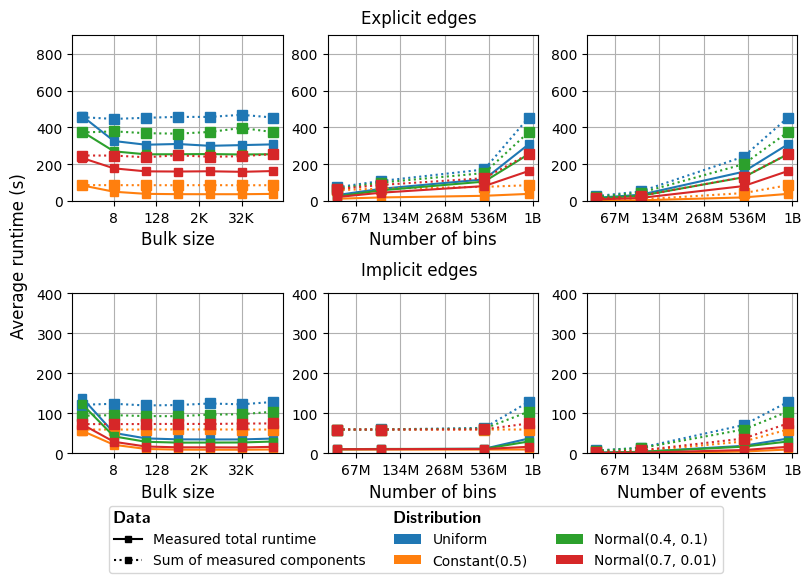

In [304]:
save = True; figname = f"{output_folder}/cpu_total_vs_inner.pdf"
selected_env = "CPU" 
selected_bulksize = 262144
selected_nbins = 10e6
selected_nvals = 1e9
selected_distr = unique_distribution

# fig = plt.figure(figsize=(8, 5))
fig = plt.figure(constrained_layout=True, figsize=(8,5))
(subfig1, subfig2) = fig.subfigures(2, 1) # create 2x1 subfigures
(ax1, ax2,ax3) = subfig1.subplots(1, 3)       # create 1x2 subplots on subfig1
(ax4, ax5,ax6) = subfig2.subplots(1, 3)       # create 1x2 subplots on subfig2
axes = [ax1,ax2,ax3,ax4,ax5,ax6]

hmax = 900
for edi, edg in enumerate([True, False]):
    ax = axes[edi*3]
    for di,distr in enumerate(selected_distr):
        arg = selected_env, distr, selected_nvals, selected_nbins, ivd_unique_bulksize, edg
        ttotal_avg = gp_vd.mean().loc[arg]["ttotal"]
        ttotal_std = gp_vd.std().loc[arg]["ttotal"]
        p = ax.errorbar(ivd_unique_bulksize, ttotal_avg, yerr=ttotal_std, 
                     marker="s", ecolor="k", 
                     # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
                     # label=f"{distr} total"
                    )
        tfill_avg = gp_ivd.mean().loc[arg]["tfill"]
        tfill_std = gp_ivd.std().loc[arg]["tfill"]
        tusb_avg = gp_ivd.mean().loc[arg]["tstats"]
        tusb_std = gp_ivd.std().loc[arg]["tstats"]
        tfindbin_avg = gp_ivd.mean().loc[arg]["tfindbin"]
        tfindbin_std = gp_ivd.std().loc[arg]["tfindbin"]
        p = ax.errorbar(ivd_unique_bulksize, 
                         tfill_avg + tusb_avg + tfindbin_avg, 
                         yerr=tfill_std + tusb_std + tfindbin_std, 
                         color=p[0].get_color(), **sum_style,
                        )

    ax.set_xlabel("Bulk size", fontsize=12)
    ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    ax.set_ylim([0,hmax - (not edg) * 500])
    # plt.ylabel("Average runtime (s)")
    
    ###########
    ax = axes[edi*3+1]
    for di,distr in enumerate(selected_distr):
        arg = selected_env, distr, selected_nvals, unique_nbins, selected_bulksize, edg
        ttotal_avg = gp_vd.mean().loc[arg]["ttotal"]
        ttotal_std = gp_vd.std().loc[arg]["ttotal"]
        p = ax.errorbar(unique_nvals, ttotal_avg, yerr=ttotal_std, 
                     marker="s", ecolor="k", 
                     # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
                     # label=f"{distr} total"
                    )
        tfill_avg = gp_ivd.mean().loc[arg]["tfill"]
        tfill_std = gp_ivd.std().loc[arg]["tfill"]
        tusb_avg = gp_ivd.mean().loc[arg]["tstats"]
        tusb_std = gp_ivd.std().loc[arg]["tstats"]
        tfindbin_avg = gp_ivd.mean().loc[arg]["tfindbin"]
        tfindbin_std = gp_ivd.std().loc[arg]["tfindbin"]
        p = ax.errorbar(unique_nvals, 
                         tfill_avg + tusb_avg + tfindbin_avg, 
                         yerr=tfill_std + tusb_std + tfindbin_std, 
                         color=p[0].get_color(), **sum_style
                        )

    ax.set_xlabel("Number of bins", fontsize=12)
    ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    # plt.ylim([0, 50])
    ax.set_ylim([0,hmax - (not edg) * 500])
    # plt.ylabel("Average runtime (s)")
    
    ###########
    ax = axes[edi*3+2]
    ax.plot(0,0, label="Measured total runtime", c="k", marker="s", markersize=5)
    ax.plot(0,0, label="Sum of measured components", c="k", marker="s", ls=":",  markersize=5)
    for di,distr in enumerate(selected_distr):
        arg = selected_env, distr, unique_nvals, selected_nbins, selected_bulksize, edg
        ttotal_avg = gp_vd.mean().loc[arg]["ttotal"]
        ttotal_std = gp_vd.std().loc[arg]["ttotal"]
        p = ax.errorbar(unique_nvals, ttotal_avg, yerr=ttotal_std, 
                     marker="s", ecolor="k", 
                     # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
                     # label=f"{distr} total"
                    )
        
        tfill_avg = gp_ivd.mean().loc[arg]["tfill"]
        tfill_std = gp_ivd.std().loc[arg]["tfill"]
        tusb_avg = gp_ivd.mean().loc[arg]["tstats"]
        tusb_std = gp_ivd.std().loc[arg]["tstats"]
        tfindbin_avg = gp_ivd.mean().loc[arg]["tfindbin"]
        tfindbin_std = gp_ivd.std().loc[arg]["tfindbin"]
        p = ax.errorbar(unique_nvals, 
                         tfill_avg + tusb_avg + tfindbin_avg, 
                         yerr=tfill_std + tusb_std + tfindbin_std, 
                         color=p[0].get_color(), **sum_style,
                        )    
        # Legend Labels
        ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, 
                                     facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"))

    plt.xlabel("Number of events", fontsize=12)
    ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    
    ax.set_ylim([0,hmax - (not edg) * 500])

# ax = plt.subplot(221)
subfig1.suptitle("Explicit edges", fontsize=12)
subfig2.suptitle("Implicit edges", fontsize=12)
# ax = plt.subplot(223)
# fig.subplots_adjust(wspace=0.2, hspace=0.5) 

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Distribution")
hndls.insert(6, "")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")
lbls.insert(6, "")
legend = fig.legend(hndls, lbls, loc='lower left', bbox_to_anchor=(0.12, -0.15), ncols=3,
                    handler_map={str: LegendTitle({'fontsize':12})})

fig.supylabel('Average runtime (s)')
# plt.tight_layout()
if save: plt.savefig(figname, format="pdf", bbox_inches='tight')

plt.show()

## Runtime

NameError: name 'T_updatestats' is not defined

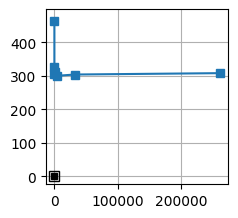

In [305]:
save = True; figname ="../../images/das6/cpu_validation_das6.pdf"
selected_env = "CPU" 
selected_bulksize = 32768
selected_nbins = 10e6
selected_nvals = 1e9
selected_distr = unique_distribution
edg = True

fig = plt.figure(figsize=(8, 5))

for edi, edg in enumerate([True, False]):
    ax = plt.subplot(2, 3, edi*3+1)
    
    ax.plot(0,0, label="Measured total runtime", c="k", marker="s", markersize=5)
    plt.plot(0,0, label="Model prediction", c="k",ls=":", marker="s", markersize=7, markerfacecolor='none')
    
    for distr in unique_distribution:
        arg = selected_env, distr, selected_nvals, selected_nbins, unique_bulksize, edg
        ttotal_avg = gp_vd.mean().loc[arg]["ttotal"]
        ttotal_std = gp_vd.std().loc[arg]["ttotal"]
        p = plt.errorbar(unique_bulksize, ttotal_avg, yerr=ttotal_std, 
                     marker="s", 
                     # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
                     # label=f"{distr} total"
                    )
    
        # Predicition in nanoseconds!
        subsize = get_subsize(distr, selected_nbins)
        tfill_pred = T_fill(selected_nbins, subsize)
        tfindbin_pred = T_findbin(edg, selected_nbins, subsize)
        tusb_pred = T_updatestats
        # print("tfill_pred:", tfill_pred)
        # print("tfindbin_pred:", tfindbin_pred)
        # print("tusb_pred:", tusb_pred)
        p = plt.errorbar(unique_bulksize, 
                         np.repeat((tfill_pred + tusb_pred + tfindbin_pred) * selected_nvals * unit_to_unit_factor("ns", "s"), 
                                   len(unique_bulksize)), 
                         color=p[0].get_color(), **pred_nocolor_style
                        )
        
        # Legend Labels
        ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, 
                                     facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"))
        
    plt.xscale("log", base=2)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    plt.xlabel("Bulk size")
        
    plt.ylim([0,900 - (not edg) * 500])
    # plt.ylabel("a")
    #######################################################
    ax = plt.subplot(2, 3, edi*3+2)
    
    # Legend Labels
    ax.plot(0,0, label="Measured total runtime", c="k", marker="s", markersize=5)
    plt.plot(0,0, label="Model prediction", c="k", marker="s", markersize=7, markerfacecolor='none')
    for distr in unique_distribution:
        arg = selected_env, distr, unique_nvals, selected_nbins, selected_bulksize, edg
        ttotal_avg = gp_vd.mean().loc[arg]["ttotal"]
        ttotal_std = gp_vd.std().loc[arg]["ttotal"]
        p = plt.errorbar(unique_nvals, ttotal_avg, yerr=ttotal_std, 
                     marker="s", 
                     # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
                     # label=f"{distr} total"
                    )
    
        # In nanoseconds!
        subsize = get_subsize(distr, selected_nbins)
        tfill_pred = T_fill(selected_nbins, subsize)
        tfindbin_pred = T_findbin(edg, selected_nbins, subsize)
        tusb_pred = T_updatestats[0]
        # print("tfill_pred:", tfill_pred)
        # print("tfindbin_pred:", tfindbin_pred)
        # print("tusb_pred:", tusb_pred)
        p = plt.errorbar(unique_nvals, 
                        (tfill_pred + tusb_pred + tfindbin_pred) * unique_nvals * unit_to_unit_factor("ns", "s"),
                         color=p[0].get_color(), **pred_nocolor_style
                        )
        
        # Legend Labels
        ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, 
                                     facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"))
    plt.xscale("log", base=2)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    plt.xlabel("Number of events")
        
    plt.ylim([0,900 - (not edg) * 500])
    plt.title(f"{'Explicit' if edg else 'Implicit'} edges")
    #######################################################
    ax = plt.subplot(2, 3, edi*3+3)
    
    # Legend Labels
    ax.plot(0,0, label="Measured total runtime", c="k", marker="s", markersize=5)
    plt.plot(0,0, label="Model prediction", c="k", marker="s", markersize=7, markerfacecolor='none')
    
    for distr in unique_distribution:
        arg = selected_env, distr, selected_nvals, unique_nbins, selected_bulksize, edg
        ttotal_avg = gp_vd.mean().loc[arg]["ttotal"]
        ttotal_std = gp_vd.std().loc[arg]["ttotal"]
        p = plt.errorbar(unique_nbins, ttotal_avg, yerr=ttotal_std, 
                     marker="s", 
                     # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
                     # label=f"{distr} total"
                    )
    
        # In nanoseconds!
        subsize = get_subsize(distr, unique_nbins)
        tfill_pred = T_fill(unique_nbins, subsize)
        tfindbin_pred = T_findbin(edg, unique_nbins, subsize)
        tusb_pred = T_updatestats[0]
        # print("tfill_pred:", tfill_pred)
        # print("tfindbin_pred:", tfindbin_pred)
        # print("tusb_pred:", tusb_pred)
        p = plt.errorbar(unique_nbins, 
                         (tfill_pred + tusb_pred + tfindbin_pred) * selected_nvals * unit_to_unit_factor("ns", "s"), 
                           color=p[0].get_color(), **pred_nocolor_style
                        )
        
        # Legend Labels
        ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, 
                                     facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"))
    
    plt.xscale("log", base=2)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    plt.xlabel("Number of bins")

    plt.ylim([0,900 - (not edg) * 500])
        
#######################################################

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Distribution")
hndls.insert(6, "")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")
lbls.insert(6, "")
legend = fig.legend(hndls, lbls, loc='lower left', bbox_to_anchor=(0.15, -0.15), ncols=3,
                    handler_map={str: LegendTitle({'fontsize':12})})

fig.supylabel('Average runtime (s)')

plt.tight_layout()
if save: plt.savefig(figname, format="pdf", bbox_inches='tight')

In [ ]:
filename = "nonbulk_1d_fixedbins.csv" 
df_bm = pd.read_csv(filename)
df_bm["nvals"] =  df_bm["input"].apply(lambda s: float(s.split("_")[-1].split(".")[0]))
df_bm["distribution"] =  df_bm["input"].apply(lambda s: s.split("_")[1])
convert_to_type(df_bm, "tfindbin", np.float64)
convert_to_type(df_bm, "tfill", np.float64)
convert_to_type(df_bm, "tstats", np.float64)
del df_bm["input"]
df_bm.head(7)

In [ ]:
gp_bm = df_bm.groupby(["env", "distribution", "nvals", "nbins", "bulksize"])
gp_bm.mean()

In [ ]:
unique_nbins = df_bm["nbins"].unique().astype(np.float64)
unique_nvals = df_bm["nvals"].unique().astype(np.float64)
unique_bulksize = df_bm["bulksize"].unique().astype(np.float64)
unique_edges = [True, False]
unique_nbins, unique_nvals, unique_bulksize

Plots the total time spent on finding bins, filling bins, and updating stats for **1D** histograms with **fixed bins**, **different** number of bins and **different** number of **doubles**. Total time averaged over **3 runs**

In [ ]:
selected_env = "CPU"
selected_bulksize = 1
selected_bins = unique_nbins
selected_nvals = 500000000
selected_distr = "uniform"
selected_edges = True

In [ ]:
plt.figure(figsize=(20,10))
plt.suptitle("Fixed Bins")

def plot_perval(title, col, xlabel, ylabel, ylim, norm=1):
    plt.title(title)
    for nv in unique_nvals:
        plt.errorbar(unique_nbins, 
                     gp_bm.mean().loc[selected_env, selected_distr, nv, :, selected_bulksize][col], 
                     yerr=gp_bm.std().loc[selected_env, selected_distr, nv, :, selected_bulksize][col], 
                     marker="o", ecolor="k", label=f"{human_readable(nv)}")
    plt.xlabel(xlabel)
    plt.ylim(ylim)
    plt.ylabel(ylabel)

def plot_perbin(title, col, xlabel, ylabel, ylim, norm=1):
    plt.title(title)
    for nb in unique_nbins:
        plt.errorbar(unique_nvals, gp_bm.mean().loc[selected_env, selected_distr, :, nb, selected_bulksize][col], 
                     yerr=gp_bm.std().loc[selected_env, selected_distr, :, nb, selected_bulksize][col], 
                     marker="o", ecolor="k", label=f"{human_readable(nb)}")
    plt.xlabel("Number of values")
    plt.ylim(ylim)
    plt.ylabel(ylabel)

ylim=[0,100]
plt.subplot(231)
plot_perval("FindBin", "tfindbin", "Number of bins",  "Total time (s)", ylim)

plt.subplot(232)
plot_perval("Fill", "tfill", "Number of bins",  "Total time (s)", ylim)

plt.subplot(233)
plot_perval("Update Stats", "tstats", "Number of bins",  "Total time (s)", ylim)
plt.legend(title="Number of values", loc='center left', bbox_to_anchor=(1, 0.5))

ylim = [0, 100]
plt.subplot(234)
plot_perbin("", "tfindbin", "Number of values",  "Total time (s)", ylim)

plt.subplot(235)
plot_perbin("", "tfill", "Number of values",  "Total time (s)", ylim)

plt.subplot(236)
plot_perbin("", "tstats", "Number of values",  "Total time (s)", ylim)
plt.legend(title="Number of bins", loc='center left', bbox_to_anchor=(1, 0.5))

Plots the *average* time spent *per value* on finding bins, filling bins, and updating stats for **1D** histograms with **fixed bins**, **different** number of bins and **different** number of **doubles**. Total time averaged over **3 runs**

In [ ]:
plt.figure(figsize=(20,10))
plt.suptitle("Fixed Bins")

def plot_perval_normalized(title, col, xlabel, ylabel, ylim, norm=1):
    plt.title(title)
    for nv in unique_nvals:
        plt.errorbar(unique_nbins, gp_bm.mean().loc[selected_env, selected_distr, nv, :, selected_bulksize][col]/nv/norm, 
                     yerr=gp_bm.std().loc[selected_env, selected_distr, nv, :, 1][col]/nv/norm, 
                     marker="o", capsize=2, label=f"{int(nv)}")
    plt.xlabel(xlabel)
    plt.ylim(ylim)
    plt.ylabel(ylabel)

def plot_perbin_normalized(title, col, xlabel, ylabel, ylim, norm=1):
    plt.title(title)
    for nb in unique_nbins:
        plt.errorbar(unique_nvals, gp_bm.mean().loc[selected_env, selected_distr, :, nb, selected_bulksize][col]/unique_nvals/norm, 
                     yerr=gp_bm.std().loc[selected_env, selected_distr, :, nb, selected_bulksize][col]/unique_nvals/norm, 
                     marker="o",  capsize=2, label=f"{int(nb)}")
    plt.xlabel("Number of values")
    plt.ylim(ylim)
    plt.ylabel("Average time per value (s)")

norm = 1e-9
ylim = [13, 20]
plt.subplot(231)
plot_perval_normalized("FindBin", "tfindbin", "Number of bins",  
                       "Average time per value (ns)", ylim, norm)

plt.subplot(232)
plot_perval_normalized("Fill", "tfill", "Number of bins",  
                       "Average time per value (ns)", ylim, norm)

plt.subplot(233)
plot_perval_normalized("Update Stats", "tstats", "Number of bins",  
                       "Average time per value (ns)", ylim, norm)
plt.legend(title="Number of values", loc='center left', bbox_to_anchor=(1, 0.5))

ylim = [13, 20]
plt.subplot(234)
plot_perbin_normalized("", "tfindbin", "Number of values",  
                       "Average time per value (ns)", ylim, norm)

plt.subplot(235)
plot_perbin_normalized("", "tfill", "Number of values",  
                       "Average time per value (ns)", ylim, norm)

plt.subplot(236)
plot_perbin_normalized("", "tstats", "Number of values",  
                       "Average time per value (ns)", ylim, norm)
plt.legend(title="Number of bins", loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

#### root plot

In [ ]:
%jsroot off

selected_env = "CPU"
selected_bulksize = 1
selected_bins = unique_nbins
selected_nvals = 500000000
selected_distr = "uniform"
selected_edges = True

c = ROOT.TCanvas("c1", "")
rmargin = 0.18
c.SetRightMargin(rmargin)
l = ROOT.TLegend(1.01-rmargin, 0.3, 1, 0.9)
l.SetHeader("Number of bins")
header = l.GetListOfPrimitives().First();
header.SetTextSize(0.05)

title=""
mg = ROOT.TMultiGraph("mg", title)
for nbi, nb in enumerate(selected_bins):
    g = ROOT.TGraphErrors(len(unique_nvals), unique_nvals, 
                          gp_bm.mean().loc[selected_env, selected_distr, :, nb, selected_bulksize]
                                          ["tfindbin"].values/unique_nvals/norm,
                          ROOT.kNone,
                          gp_bm.std().loc[selected_env, selected_distr, :, nb, selected_bulksize]
                                          ["tfindbin"].values/unique_nvals/norm)
    g.SetMarkerStyle(20 + nbi)
    g.SetLineWidth(3)
    mg.Add(g, "PL")
    l.AddEntry(g, str(nb))
mg.Draw("A PLC PMC")

xaxis = mg.GetXaxis()
xaxis.SetTitle("Number of values")

yaxis = mg.GetYaxis()
yaxis.SetTitle("Average time per values (ns)")

l.Draw()
c.SaveAs("findbin_benchmark.pdf")
c.DrawClone()

In [ ]:
filename = "nonbulk_1d_varbins.csv" 
df_bm = pd.read_csv(filename)
df_bm["nvals"] =  df_bm["input"].apply(lambda s: float(s.split("_")[-1].split(".")[0]))
df_bm["distribution"] =  df_bm["input"].apply(lambda s: s.split("_")[1])
convert_to_type(df_bm, "tfindbin", np.float64)
convert_to_type(df_bm, "tfill", np.float64)
convert_to_type(df_bm, "tstats", np.float64)
del df_bm["input"]
df_bm.head(7)

In [ ]:
gp_bm = df_bm.groupby(["env", "distribution", "nvals", "nbins", "bulksize"])
gp_bm.mean()

In [ ]:
unique_nbins = df_bm["nbins"].unique().astype(np.float64)
unique_nvals = df_bm["nvals"].unique().astype(np.float64)
unique_bulksize = df_bm["bulksize"].unique().astype(np.float64)
unique_nbins, unique_nvals, unique_bulksize

Plots the *average* time spent *per value* on finding bins, filling bins, and updating stats for **1D** histograms with **fixed bins**, **different** number of bins and **0.5B** number of **doubles**. Total time averaged over **3 runs**

In [ ]:
plt.figure(figsize=(20,5))
plt.suptitle("Variable Bins")

norm=1
ylim = [0*1e-8, 5.5*1e-8]
plt.subplot(131)
plot_perval_normalized("FindBin", "tfindbin", "Number of bins",  "Average time per value (ns)", ylim, norm)

plt.subplot(132)
plot_perval_normalized("Fill", "tfill", "Number of bins",  "Average time per value (ns)", ylim, norm)

plt.subplot(133)
plot_perval_normalized("Update Stats", "tstats", "Number of bins",  "Average time per value (ns)", ylim, norm)
plt.legend(title="Number of values", loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [ ]:
def convert_to_double_list(df, col):
    df[col] =  df[col].apply(lambda s: [np.float64(x) for x in s.split()])
    
filename = "nonbulk_1d_pervarbin.csv" 
df_bm = pd.read_csv(filename)
df_bm["nvals"] =  df_bm["input"].apply(lambda s: float(s.split("_")[-1].split(".")[0]))
df_bm["distribution"] =  df_bm["input"].apply(lambda s: s.split("_")[1])
convert_to_double_list(df_bm, "tfindbin")
convert_to_double_list(df_bm, "tfill")
convert_to_type(df_bm, "tstats", np.float64)
del df_bm["input"]
df_bm.head(7)

Plots the *average* time spent on finding a specific bin in an array with **100** bins for **0.5B** number of **doubles**. Total time averaged over **3 runs**

In [ ]:
# w = 2400
# h = 900
# c = ROOT.TCanvas("c1", title, w, h)
# c.SetRightMargin(0.32)
# c.SetBottomMargin(0.33)
# c.Divide(2,1)

# l = ROOT.TLegend(0.7, 0.7, 0.96, 0.9)
# l.SetTextSize(0.05)

# g = ROOT.TGraph(100, np.arange(100, dtype=np.float64), gp_bm.agg(mean_list).loc["CPU", "uniform", 500000000, 100, 1]["tfindbin"][1:-1])
# g.SetMarkerSize(1)
# g.SetMarkerStyle(8)
# l.AddEntry(g, "Microbenchmark", "p")
# xaxis = g.GetXaxis()
# xaxis.SetTitle("Bin")
# yaxis = g.GetYaxis()
# yaxis.SetTitle(f"Time (ns)")
# xaxis.SetRangeUser(0, 100)

# c.cd(1)
# g.Draw("ALP")

# title="Time to find bin in an array with 100 bins"
# g.SetTitle(title)

# l.Draw()
# c.Draw()

Investigate caching within Histogram Filling

In [ ]:
filename = "das6-cpu/20231219-223056" 
df_bm = pd.read_csv(filename)
df_bm["nvals"] =  df_bm["input"].apply(lambda s: float(s.split("_")[-1].split(".")[0]))
df_bm["distribution"] =  df_bm["input"].apply(lambda s: s.split("_")[1])
convert_to_type(df_bm, "tfindbin", np.float64)
convert_to_type(df_bm, "tfill", np.float64)
convert_to_type(df_bm, "tstats", np.float64)
convert_to_type(df_bm, "edges", np.bool_)
del df_bm["input"]
df_bm.head(7)

In [ ]:
gp_bm = df_bm.groupby(["env", "distribution", "nvals", "nbins", "bulksize", "edges"])
gp_bm.mean()

In [ ]:
unique_nbins = df_bm["nbins"].unique().astype(np.float64)
unique_nvals = df_bm["nvals"].unique().astype(np.float64)
unique_bulksize = df_bm["bulksize"].unique().astype(np.float64)
unique_distribution = df_bm["distribution"].unique()
unique_edges = [True, False]
unique_nbins, unique_nvals, unique_bulksize

In [ ]:
selected_env = "CPU"
selected_bulksize = 32768
selected_bins = unique_nbins[:-1]
selected_nvals = 500000000
selected_distr = "constant-0"
selected_edges = True

def plot_perbulk_normalized(title, col, xlabel, ylabel, xlim, ylim, norm=1):
    plt.title(title)
    for bs in unique_bulksize:
        plt.errorbar(unique_nbins, 
                     gp_bm.mean().loc[selected_env, selected_distr, selected_nvals, :, bs, selected_edges][col]/norm, 
                     yerr=gp_bm.std().loc[selected_env, selected_distr, selected_nvals, :, bs, selected_edges][col]/norm,
                     marker="o", capsize=3, label=f"{int(bs)}")
    plt.xlabel(xlabel)
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    plt.ylabel(ylabel)

def plot_perbin_normalized(title, col, xlabel, ylabel, xlim, ylim, norm=1):
    plt.title(title)
    for nb in unique_nbins:
        plt.errorbar(unique_bulksize, 
                     gp_bm.mean().loc[selected_env, selected_distr, selected_nvals, nb, :, selected_edges][col]/norm, 
                     yerr=gp_bm.std().loc[selected_env, selected_distr, selected_nvals, nb, :, selected_edges][col]/norm, 
                     marker="o", capsize=3, label=f"{int(nb)}")
    plt.xlabel(xlabel)
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    plt.ylabel(ylabel)
    
plt.figure(figsize=(20,10))
plt.suptitle("Fixed Bins with Bulk API")

norm=selected_nvals*1e-9
xlim = []
ylim = []
plt.subplot(231)
plot_perbulk_normalized("FindBin", "tfindbin", "Number of bins",  "Average time per value (ns)", xlim, ylim, norm)

plt.subplot(232)
plot_perbulk_normalized("Fill", "tfill", "Number of bins",  "Average time per value (ns)", xlim, ylim, norm)

plt.subplot(233)
plot_perbulk_normalized("Update Stats", "tstats", "Number of bins",  "Average time per value (ns)", xlim, ylim, norm)
plt.legend(title="Bulk size", loc='center left', bbox_to_anchor=(1, 0.5))

norm=1e-9
xlim = []
ylim = []
plt.subplot(234)
plot_perbin_normalized("", "tfindbin", "Bulk size",  "Average time per value (ns)", xlim, ylim, norm)

plt.subplot(235)
plot_perbin_normalized("", "tfill", "Bulk size",  "Average time per value (ns)", xlim, ylim, norm)

plt.subplot(236)
plot_perbin_normalized("", "tstats", "Bulk size",  "Average time per value (ns)", xlim, ylim, norm)
plt.legend(title="Number of bins", loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

Plot average total time. **Note that this timing includes overhead of timers for the measurements above**

In [ ]:
plt.figure(figsize=(10,5))
plt.suptitle("Fixed Bins")

norm=1
xlim = []
ylim = []
plt.subplot(111)
plot_perbin_normalized("Total runtime on CPU with bulk API", "ttotal", "Bulk Size", "Total runtime (s)", xlim, ylim, norm)
plt.legend(title="Number of bins", loc='center left', bbox_to_anchor=(1, 0.5))

**ROOT plot** Plot average time per value for different number of bins

In [ ]:
%jsroot off

selected_env = "CPU"
selected_bulksize = 32768
selected_bins = unique_nbins
selected_distr = "constant-0.5"
selected_edges = True
norm = unique_nvals/1e9

c = ROOT.TCanvas("c1", "")
rmargin = 0.2
c.SetRightMargin(rmargin)
l = ROOT.TLegend(1.01-rmargin, 0.55, 1, 0.9)
l.SetHeader("Number of bins")
header = l.GetListOfPrimitives().First();
header.SetTextSize(0.05)

title=""
mg = ROOT.TMultiGraph("mg", title)
for nbi, nb in enumerate(selected_bins):
    g = ROOT.TGraphErrors(len(unique_nvals), unique_nvals, 
                          gp_bm.mean().loc[selected_env, selected_distr, :, nb, selected_bulksize, selected_edges]
                                          ["tfindbin"].values/norm,
                          ROOT.kNone,
                          gp_bm.std().loc[selected_env, selected_distr, :, nb, selected_bulksize, selected_edges]
                                          ["tfindbin"].values/norm)
    g.SetMarkerStyle(20 + nbi)
    g.SetLineWidth(3)
    mg.Add(g, "PL")
    l.AddEntry(g, human_readable(nb))
mg.Draw("A PLC PMC")

xaxis = mg.GetXaxis()
xaxis.SetTitle("Number of values")

yaxis = mg.GetYaxis()
yaxis.SetTitle("Average time per values (ns)")

l.Draw()
c.SaveAs("../../images/findbin_nvals_vs_nbins.pdf")
c.DrawClone()

In [ ]:
%jsroot off

selected_env = "CPU"
selected_bulksize = 32768
selected_bins = []
selected_distr = "constant-0.5"
selected_edges = True
selected_nvals = 500e6
norm = selected_nvals*1e-9

c = ROOT.TCanvas("c1", "")
rmargin = 0.2
c.SetRightMargin(rmargin)
l = ROOT.TLegend(1.01-rmargin, 0.55, 1, 0.9)
l.SetHeader("Input type")
header = l.GetListOfPrimitives().First();
header.SetTextSize(0.05)

title=""
mg = ROOT.TMultiGraph("mg", title)
for (nbi, dis), lbl in zip(enumerate(unique_distribution), ["Uniform", "Bin 0", "Middle bin"]):
    g = ROOT.TGraphErrors(len(unique_nbins), unique_nbins, 
                          gp_bm.mean().loc[selected_env, dis, selected_nvals, :, selected_bulksize, selected_edges]
                                          ["tfindbin"].values/norm,
                          ROOT.kNone,
                          gp_bm.std().loc[selected_env, dis, selected_nvals, :, selected_bulksize, selected_edges]
                                          ["tfindbin"].values/norm)
    g.SetMarkerStyle(20 + nbi)
    g.SetLineWidth(3)
    mg.Add(g, "PL")
    l.AddEntry(g, str(dis).title())
mg.Draw("A PLC PMC")

xaxis = mg.GetXaxis()
xaxis.SetTitle("Number of bins")
# c.SetLogx()
0000
yaxis = mg.GetYaxis()
yaxis.SetTitle("Average time per values (ns)")

l.Draw()
c.SaveAs("../../images/findbin_nbins_vs_distr.pdf")
c.DrawClone()

In [ ]:
filename = "../microbenchmarks/das6-cpu/gbenchmark_evaluation.json" 
with open(filename, "r") as f:
    jdata = json.load(f)
bm_df = pd.DataFrame.from_dict(jdata["benchmarks"]).astype({"real_time" : float})

convert_to_type(df, "real_time", np.float64)
bm_df["func_name"] = bm_df["name"].apply(lambda s: s.split("/")[0][3:])
bm_df["time_factor"] = bm_df["time_unit"].apply(convert_unit)
# bm_df["time (s)"] = bm_df["real_time"] * bm_df["time_unit"].apply(convert_unit)
del bm_df["family_index"], bm_df["per_family_instance_index"]

gbm_df = bm_df.loc[bm_df["name"].str.contains("Search")].copy()
n_param = len(gbm_df["name"].values[0].split("/")) - 1
for i in range(n_param):
    if i == n_param - 1:
        gbm_df[f"param_{i}"] = gbm_df["name"].apply(lambda s: s.split("/")[i+1].split("_")[0])
    else:
        gbm_df[f"param_{i}"] = gbm_df["name"].apply(lambda s: s.split("/")[i+1])

gbm_mean = gbm_df.loc[gbm_df["name"].str.contains("mean")]
gbm_std = gbm_df.loc[gbm_df["name"].str.contains("stddev")]
gbm_mean

In [ ]:
%jsroot off

selected_nbins = gbm_mean["nbins"].unique().astype(np.float64)
selected_bin = gbm_mean["bin"].unique().astype(np.float64)
selected_val = gbm_mean["bin"].unique().astype(np.float64)
selected_func = gbm_mean["func_name"].unique()

c = ROOT.TCanvas("c1", "")
rmargin = 0.35
bmargin = 0
c.SetRightMargin(rmargin)
# c.SetBottomMargin(bmargin)
l = ROOT.TLegend(1.01-rmargin,0.55, 1, 0.9)
l.SetTextSize(0.05)
l.SetHeader("#bf{Performance Counter}")

title=""
mg = ROOT.TMultiGraph("mg", title)
for ev in [
           # "INSTRUCTIONS", 
           "L1-dcache-load-misses", 
           "L1-dcache-loads",
           "cache-misses",
           "cache-references"]:
    avg = np.array(gbm_mean[ev] / gbm_mean["repetitions"])
    g = ROOT.TGraphErrors(len(selected_nbins), selected_nbins, 
                          avg,
                          ROOT.kNone,
                          ROOT.kNone)
    g.SetMarkerStyle(20 + nbi)
    g.SetLineWidth(3)
    mg.Add(g, "PL")
    l.AddEntry(g, ev.title())      

mg.Draw("A PLC PMC")

xaxis = mg.GetXaxis()
xaxis.SetTitle("Array Size")
# xaxis.SetRangeUser(1, 10000000);
# c.SetLogx()
# c.SetLogy()

yaxis = mg.GetYaxis()
yaxis.SetTitle("Count")
# yaxis.SetTitle("Total time (s)")columnscolumnscolumnscolumns

l.Draw()      
# c.SaveAs("../../images/mb_findbin_nbins_vs_bin.pdf")
c.DrawClone()

In [ ]:
selected_val = "0"
avg_df = gbm_mean.loc[gbm_mean["param_1"] == selected_val]
std_df = gbm_std.loc[gbm_std["param_1"] == selected_val]

plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
norm = 1e3

for ev, clr, mrkr in [
           ["INSTRUCTIONS", "k", "o"],
           ["L1-dcache-loads", "k", "v"],
           ["L1-dcache-load-misses", "k", "v"],
           ["cache-references", "k", "x"],
           ["cache-misses", "k", "x"],
]:
    avg = np.array(avg_df[ev] / avg_df["repetitions"])
    std = np.array(std_df[ev] / std_df["repetitions"])
    ax.errorbar((avg_df["nbins"]*8)/norm, avg, label=ev.title(), ls=("-" if not "miss" in ev else "--"), 
                 c=clr, marker=mrkr, yerr=std, markersize=8)


hmin, hmax = ax.get_ylim()
# hmin, hmax = 1e-8, 1e8
div = 1.4
l1_size
vclr="tab:red"
plt.vlines(l1_size/norm, ymin=hmin, ymax=hmax, color=vclr)
plt.text(l1_size/norm - 7, hmax/div, "32KB L1 Cache", rotation=90, color=vclr)
plt.vlines(l2_size/norm, ymin=hmin, ymax=hmax, color=vclr)
plt.text(l2_size/norm - 140, hmax/div, "512KB L2 Cache", rotation=90, color=vclr)
plt.vlines(l3_size/norm, ymin=hmin, ymax=hmax, color=vclr)
plt.text(l3_size/norm - 3900, hmax/div, "16MB L3 Cache", rotation=90, color=vclr)

plt.xlabel("Array Size (KB)")
# plt.ylabel(f"Benchmarked time ({bm_mean['time_unit'][0]})")
plt.ylabel(f"Average count")
plt.xscale("log", base=2)
# plt.yscale("log")
plt.ylim([0, hmax])
# plt.xlim([0.0005, 32])
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
# plt.ticklabel_format(axis='x', style='plain')

plt.legend(loc="upper left")
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
unit = "ns"
# ax2.set_ylim(
#     bottom=0,
    # top=,
# )
ax2.set_ylabel(f"Average runtime ({unit})", color=color)
# ax2.set_yscale("log")
avg = np.array(avg_df["real_time"] / avg_df["repetitions"]) * unit_to_unit_factor(avg_df['time_unit'].values[0], unit)
std = np.array(std_df["real_time"] / std_df["repetitions"])
ax2.errorbar((avg_df["nbins"]*8)/norm, avg, label=ev.title(),
              c=color, marker="s", yerr=std, markersize=5)
ax2.tick_params(axis='y', labelcolor=color)


# plt.grid()
# plt.title("LMBench results of memory read latency with different strides and array sizes on ")
plt.tight_layout()
# plt.savefig("../../images/linsearch_perfcnt_vs_size.pdf",format="pdf", bbox_inches='tight')
plt.show()

In [ ]:
selected_val = gbm_mean["param_1"].unique()
# selected_val = ["0", "2", "4"]

fig = plt.figure(figsize=(10, 5))
gs =  gridspec.GridSpec(1, 2, width_ratios=[2, 1]) 
ax = plt.subplot(gs[0])
norm = 1e3

colors = cm.tab10(np.arange(len(selected_val)))
for vi, val in enumerate(selected_val):
    for ev, clr, mrkr in [
               ["INSTRUCTIONS", "k", "o"],
               ["L1-dcache-loads", "k", "v"],
               ["L1-dcache-load-misses", "k", "v"],
               ["cache-references", "k", "x"],
               ["cache-misses", "k", "x"],
    ]:
        if vi == 0:
            ax.errorbar(0,0, label=ev.title(), ls=("-" if not "miss" in ev else "--"), 
                    c=clr, marker=mrkr, markersize=8)
        
        avg_df = gbm_mean.loc[gbm_mean["param_1"] == val]
        std_df = gbm_std.loc[gbm_std["param_1"] == val]
        avg = np.array(avg_df[ev] / avg_df["repetitions"])
        std = np.array(std_df[ev] / std_df["repetitions"])
        p = ax.errorbar((avg_df["nbins"]*8)/norm, avg, c=colors[vi],
                        ls=("-" if not "miss" in ev else "--"), 
                        marker=mrkr, yerr=std, markersize=8)


hmin, hmax = ax.get_ylim()
# hmin, hmax = 1e-8, 1e8
div = 1e1
vclr="k"
plt.vlines(l1_size/norm, ymin=hmin, ymax=hmax, color=vclr)
plt.text(l1_size/norm - 13, div, "32KB L1 Cache", rotation=90, color=vclr)
plt.vlines(l2_size/norm, ymin=hmin, ymax=hmax, color=vclr)
plt.text(l2_size/norm - 180, div, "512KB L2 Cache", rotation=90, color=vclr)
plt.vlines(l3_size/norm, ymin=hmin, ymax=hmax, color=vclr)
plt.text(l3_size/norm - 7000, div, "16MB L3 Cache", rotation=90, color=vclr)

plt.xlabel("Array Size (KB)")
# plt.ylabel(f"Benchmarked time ({bm_mean['ime_unit'][0]})")
plt.ylabel(f"Average count")
plt.xscale("log", base=2)
plt.yscale("symlog")
plt.ylim([0, hmax])
# plt.xlim([0.0005, 32])
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
# plt.ticklabel_format(axis='x', style='plain')

yaxis = plt.gca().yaxis
yaxis.set_minor_locator(MinorSymLogLocator(1e-1))
ax.grid(True, which="major")
################################################

# ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2 = plt.subplot(gs[1])
acolor = 'k'
unit = "ms"
ax2.set_xlabel(f"Number of bins (x{int(norm)})")
ax2.set_ylabel(f"Average runtime ({unit})", color=acolor)
ax2.set_xscale("log", base=2)
# ax2.set_yscale("symlog")
ax2.tick_params(axis='y', labelcolor=acolor)
ax2.xaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
for vi, val in enumerate(selected_val):
    avg_df = gbm_mean.loc[gbm_mean["param_1"] == val]
    std_df = gbm_std.loc[gbm_std["param_1"] == val]
    avg = np.array(avg_df["real_time"] / avg_df["repetitions"]) * unit_to_unit_factor(avg_df['time_unit'].values[0], unit)
    std = np.array(std_df["real_time"] / std_df["repetitions"])
    ax2.errorbar((avg_df["nbins"])/norm, avg, 
                  c=colors[vi], marker="s", yerr=std, markersize=5)

    ax2.add_patch(ptchs.Rectangle((0, 0), 0, 0,
        facecolor=colors[vi], label=f"v = {int(val)/4.}"))

hmin, hmax = ax2.get_ylim()
div = 1
vclr="k"
ax2.vlines(l1_size/8/norm, ymin=hmin, ymax=hmax, color=vclr)
ax2.text(l1_size/8/norm - 2.5, div, "32KB L1 Cache", rotation=90, color=vclr)
ax2.vlines(l2_size/8/norm, ymin=hmin, ymax=hmax, color=vclr)
ax2.text(l2_size/8/norm - 42.5, div, "512KB L2 Cache", rotation=90, color=vclr)
ax2.vlines(l3_size/8/norm, ymin=hmin, ymax=hmax, color=vclr)
ax2.text(l3_size/8/norm - 1400, div, "16MB L3 Cache", rotation=90, color=vclr)
ax2.set_ylim([0, hmax]
    # bottom=0,
    # top=,
)
ax2.grid(True, which="both")

###################################################3

# plt.legend(loc="upper left")
# handles, labels = plt.gca().get_legend_handles_labels()
hndls = ["Performance Counters"]
hndls.extend(ax.get_legend_handles_labels()[0])
hndls.append("Bin = array_size * v")
hndls.extend(ax2.get_legend_handles_labels()[0])

lbls = [""]
lbls.extend(ax.get_legend_handles_labels()[1])
lbls.append("")
lbls.extend(ax2.get_legend_handles_labels()[1])

legend = fig.legend(hndls, lbls, loc='center left', bbox_to_anchor=(0.99, 0.71),
                    handler_map={str: LegendTitle({'fontsize':12})})

# plt.grid()
# plt.title("LMBench results of memory read latency with different strides and array sizes on ")
plt.tight_layout()
# plt.savefig("../../images/linsearch_perfcnt_vs_size.pdf",format="pdf", bbox_inches='tight')
plt.show()

In [ ]:
ax.get_legend_handles_labels()), axis=0)

In [ ]:
gbm_mean.loc[gbm_mean["param_1"] == "1"]["L1-dcache-load-misses"]/gbm_mean.loc[gbm_mean["param_1"] == "1"]["L1-dcache-loads"]*100

In [ ]:
1 * unit_to_unit_factor("ns", "s")